In [50]:
#
#   The finest level of geographical information we have in the taxi data is the
#   LocationID. Ideally, we would analyze our data on this level of granularity.
#   However, a glance at the data shows that there is insufficient data (considering
#   only one month of data) in many areas. Here, we define clusters of LocationIDs,
#   which we will consider for all further analysis as one effective zone. The
#   clusters will be chosen such that each cluster has sufficient data to accurately
#   estimate the tip distribution.
#
#   We apply the following algorithm:
#
#    1. Initialize EffectiveLocationID = LocationID
#
#    2. while min data points in cluster < N \approx 5000:
#       i. For each EffectiveLocationID, compute its centroid.
#       ii. Compute the nearest neighbor for each EffectiveLocationID based
#         on the Euclidean distance between the corresponding centroids
#       iii. find EffectiveLocationID with the fewest data points and reassign
#         it to the EffectiveLocationID of its nearest neighbor
#
#   The implementation below is inefficient (unscalable), but works fine for the
#   size of data we have here.
#

In [51]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 18)

from matplotlib import pyplot as plt
import shapefile
import pandas as pd
import numpy as np

In [52]:
# read in yellow cab trip data
# we only need to know counts of data points by LocationID for this analysis
yellow = pd.read_csv('tripdata_2017-06_PROCESSED.csv', usecols=['PULocationID'])
yellow = yellow.groupby('PULocationID').apply(len).reset_index(name='Counts')

# read in TLC region data
sf  = shapefile.Reader('taxi_zones.shp')
sf.fields

[('DeletionFlag', 'C', 1, 0),
 ['OBJECTID', 'N', 9, 0],
 ['Shape_Leng', 'F', 19, 11],
 ['Shape_Area', 'F', 19, 11],
 ['zone', 'C', 254, 0],
 ['LocationID', 'N', 4, 0],
 ['borough', 'C', 254, 0]]

## 0 Compute Taxi Zone Centroids

In [53]:
# NYC limits (for plotting)
x_ = sum([[z[0] for z in zone.points] for rec, zone in zip(sf.records(), sf.shapes()) if rec[-1] != 'Staten Island'], [])
y_ = sum([[z[1] for z in zone.points] for rec, zone in zip(sf.records(), sf.shapes()) if rec[-1] != 'Staten Island'], [])
xmin, xmax = 0.99 * min(x_), 1.01 * max(x_)
ymin, ymax = 0.99 * min(y_), 1.01 * max(y_)

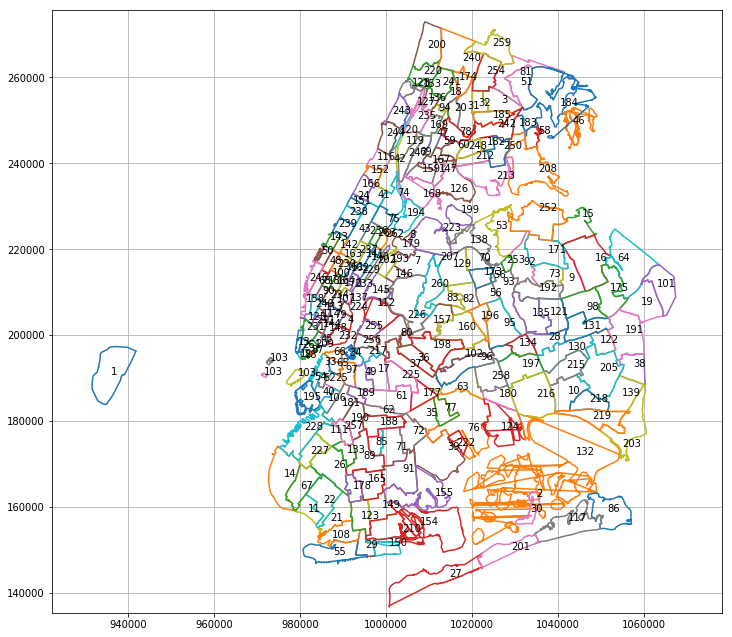

In [54]:
location_id, center_x, center_y = [], [], []

for rec, zone in zip(sf.records(), sf.shapes()):
    
    # Staten Island has _so_ little data, and is so geographically isolated, 
    # I don't even want to risk letting it participate in this algorithm, 
    # lest it tries to attach itself to Brooklyn. We won't use the Staten Island data
    # anyway, so just skip it here.
    if rec[-1] == 'Staten Island': continue

    locID = rec[-2]
    location_id.append(locID)
    
    x = [z[0] for z in zone.points]
    y = [z[1] for z in zone.points]
    
    center_x.append(np.mean(x))
    center_y.append(np.mean(y))

    # visually check centroid sanity
    plt.plot(x, y) 
    plt.text(center_x[-1], center_y[-1], locID)

plt.gca().set_aspect(1)
plt.gca().grid()
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])

locations = pd.DataFrame({
    'LocationID':location_id,
    'center_x':center_x,
    'center_y':center_y})

# 1 Initialize EffectiveLocationID and Cluster Counts

In [55]:
locations['EffectiveLocationID'] = locations['LocationID']
locations = locations.merge(yellow, left_on = 'LocationID', right_on = 'PULocationID')
del locations['PULocationID']
locations.head()

,LocationID,center_x,center_y,EffectiveLocationID,Counts
0,1,9.359210e+05,190798.948561,1,31
1,2,1.034880e+06,162357.340842,2,7
2,3,1.026705e+06,254200.631614,3,108
3,4,9.911216e+05,202996.758991,4,15339
4,7,1.006588e+06,216697.807984,7,26586


# 2 Construct Clusters

In [56]:
def get_nearest_neighbors(locations):

    # compute centroids of EffectiveLocations
    eff_locations = locations.groupby('EffectiveLocationID').agg(
        {'center_x':'mean', 'center_y':'mean'}).reset_index()

    # compute pair-wise distances on EffectiveLocationID
    eff_locations['dummy'] = 1
    eff_locations = eff_locations.merge(eff_locations, on='dummy', suffixes=['_1', '_2'])
    eff_locations['distance_sq'] = \
        (eff_locations['center_x_1'] - eff_locations['center_x_2'])**2 + \
        (eff_locations['center_y_1'] - eff_locations['center_y_2'])**2

    # extract nearest neighbors
    eff_locations['rank'] = eff_locations.groupby('EffectiveLocationID_1').rank()['distance_sq']
    eff_locations = eff_locations[eff_locations['rank'] == 2]
    
    return eff_locations[['EffectiveLocationID_1', 'EffectiveLocationID_2']].set_index('EffectiveLocationID_1')

get_nearest_neighbors(locations).head()

,EffectiveLocationID_2
EffectiveLocationID_1,
1,13
2,30
3,185
4,224
7,179


In [57]:
# track number of data points by EffectiveLocationID
eff_counts = locations.groupby('EffectiveLocationID').agg({'Counts':'sum'}).reset_index()
eff_counts.columns = ['EffectiveLocationID', 'EffectiveCounts']

while min(eff_counts.EffectiveCounts) < 5000:

    # Find EffectiveLocationID with fewest data
    eff_counts = locations.groupby('EffectiveLocationID').agg({'Counts':'sum'}).reset_index()
    eff_counts.columns = ['EffectiveLocationID', 'EffectiveCounts'] 
    loser = eff_counts.sort_values('EffectiveCounts').head(1).EffectiveLocationID.values[0]
    
    # Find its neighbor
    loser_neighbor = get_nearest_neighbors(locations).loc[loser]
    
    # Reassign EffectiveLocationID to the neighbor
    locations.loc[locations.EffectiveLocationID == loser, 'EffectiveLocationID'] = loser_neighbor.EffectiveLocationID_2
    
    
# remap EffectiveLocationID to "continuous" integer ID for convenience
locations['EffectiveLocationID'] = locations.rank(method='dense')['EffectiveLocationID']

In [58]:
locations.head()

,LocationID,center_x,center_y,EffectiveLocationID,Counts
0,1,9.359210e+05,190798.948561,3.0,31
1,2,1.034880e+06,162357.340842,44.0,7
2,3,1.026705e+06,254200.631614,41.0,108
3,4,9.911216e+05,202996.758991,1.0,15339
4,7,1.006588e+06,216697.807984,2.0,26586


# Visualize Clusters

27
103
103
103
199


(135314.95839419737, 275572.7369455232)

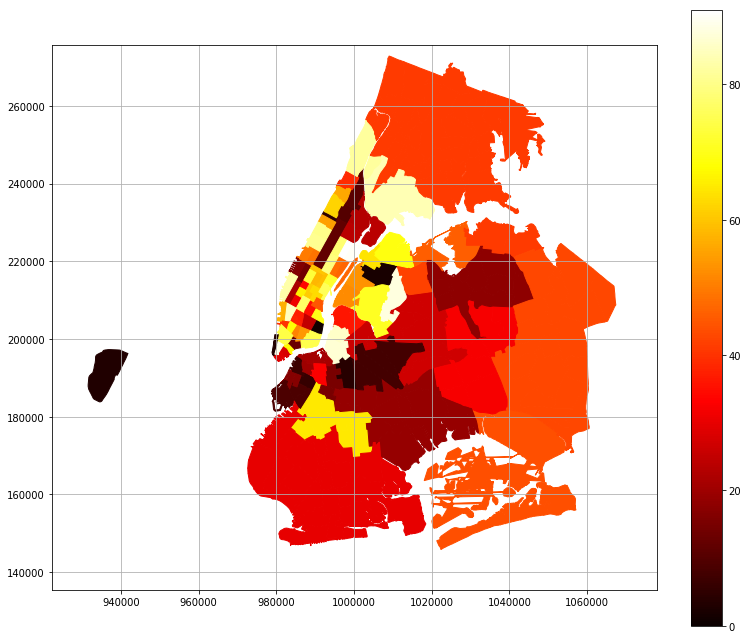

In [63]:
#
# Basic sanity check that clusters are groups of things that are near each other
#

eff_counts = locations.groupby('EffectiveLocationID').agg({'Counts':'sum'}).reset_index()
eff_counts.columns = ['EffectiveLocationID', 'EffectiveCounts'] 
    
norm = mpl.colors.Normalize(
    vmin=0,
    vmax=locations.EffectiveLocationID.max())
cmap = mpl.cm.hot
m = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

for rec, zone in zip(sf.records(), sf.shapes()):
    if rec[-1] == 'Staten Island': continue

    locID = rec[-2]
    if locID in locations.LocationID.unique():
        effLocID = locations[locations.LocationID == locID].EffectiveLocationID.values[0]
    else:
        print(locID) # CHECKME why are some IDs missing? Did I filter them out in preprocessing? 
        continue
        
    x = [z[0] for z in zone.points]
    y = [z[1] for z in zone.points]
    cb = plt.fill(x, y, c=m.to_rgba(effLocID))
        
m.set_array(cb)
cb = plt.colorbar(m, fraction=0.046)
plt.gca().set_aspect(1)
plt.gca().grid()
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])

27
103
103
103
199


(135314.95839419737, 275572.7369455232)

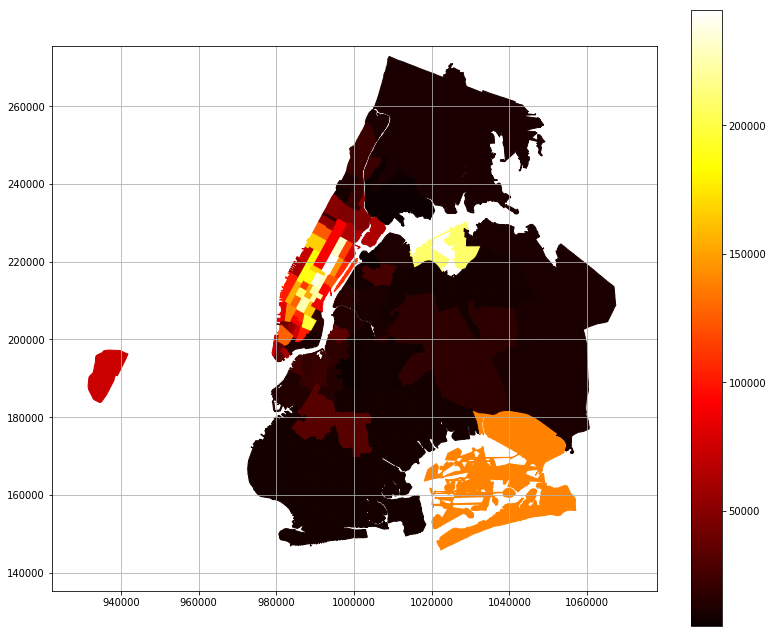

In [64]:
#
# Visualize amount of data per cluster
#
eff_counts = locations.groupby('EffectiveLocationID').agg({'Counts':'sum'}).reset_index()
eff_counts.columns = ['EffectiveLocationID', 'EffectiveCounts'] 
    
norm = mpl.colors.Normalize(
    vmin=5000, 
    vmax=eff_counts.EffectiveCounts.max())
cmap = mpl.cm.hot
m = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

for rec, zone in zip(sf.records(), sf.shapes()):
    if rec[-1] == 'Staten Island': continue

    locID = rec[-2]
    locID = rec[-2]
    if locID in locations.LocationID.unique():
        effLocID = locations[locations.LocationID == locID].EffectiveLocationID.values[0]
    else:
        print(locID)
        continue

    cnts = eff_counts[eff_counts.EffectiveLocationID == effLocID].EffectiveCounts.values[0]

    x = [z[0] for z in zone.points]
    y = [z[1] for z in zone.points]
    cb = plt.fill(x, y, c=m.to_rgba(cnts))

m.set_array(cb)
cb = plt.colorbar(m, fraction=0.046)
plt.gca().set_aspect(1)
plt.gca().grid()
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])

In [66]:
#
# Save cluster data
#
locations.to_csv('effective_location_clusters.csv', index=False)